In [1]:
import sys
# add path for my packages
sys.path.append('C:\\Users\\katsuya2\\OneDrive - University of Illinois - Urbana\\Documents\\Python Scripts\\my_packages')
import re
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import ast
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.stats import norm
import scipy.stats as stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from tqdm import tqdm
from pathlib import Path
from glob import glob
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

%precision 3
%matplotlib inline

# use my matplotlib style
style_p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/my_packages")
plt.style.use(Path(style_p, 'my_rc_setting.mplstyle'))

In [2]:
def calc_dif(idx, ito_data, glass_data):
    Eres_glass = glass_data['eres'][idx]
    Linewidth_glass = glass_data['linewidth'][idx]
    AR_glass = glass_data['ratio'][idx]

    upper_min = ito_data[ito_data['ratio'] > AR_glass]['ratio'].min()
    lower_max = ito_data[ito_data['ratio'] < AR_glass]['ratio'].max()

    if abs(upper_min - AR_glass) > abs(lower_max - AR_glass):
        AR_ito_closest = lower_max
    else:
        AR_ito_closest = upper_min

    Eres_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['eres']
    Linewidth_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['linewidth']
    dEres_IG = Eres_ito - Eres_glass
    dLinewidth_IG = Linewidth_ito - Linewidth_glass
    return dEres_IG, dLinewidth_IG


def calculate_mean(lst):
    return sum(lst) / len(lst)


def numerical_method(ito_data, glass_data, target_nsub):
    ito_nsub = 1.96
    glass_nsub = 1.52
    dnsub_IG = ito_nsub - glass_nsub
    dEres_IG_list = []
    dLinewidth_IG_list = []
    for idx in range(glass_data.shape[0]):
        dEres_IG, dLinewidth_IG = calc_dif(idx, ito_data, glass_data)
        if (dEres_IG.shape == (1,)) and (dLinewidth_IG.shape == (1,)): 
            dEres_IG_list.append(dEres_IG.values)
            dLinewidth_IG_list.append(dLinewidth_IG.values)

    dEres_IG_mean = calculate_mean(dEres_IG_list)
    dLinewidth_IG_mean = calculate_mean(dLinewidth_IG_list)
    C = dEres_IG_mean / dnsub_IG
    D = dLinewidth_IG_mean / dnsub_IG
    target_Eres = C*(target_nsub - glass_nsub) + glass_data['eres']
    target_Linewidth = D*(target_nsub - glass_nsub) + glass_data['linewidth']
    return target_Eres, target_Linewidth

In [16]:
p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/input_data/SPP2023")

glass_data = pd.read_csv(Path(p, '090723_glass_training.csv'))
glass_data = glass_data.drop(['corrcoef'], axis=1)
original_data = pd.read_csv(Path(p, 'New_SPP.csv'))
combined_data = pd.concat([glass_data, original_data], axis=0)
combined_data['volume'] = np.pi*(combined_data['width']**2)*combined_data['length']/4 - np.pi*(combined_data['width']**3)/12
combined_data['ratio'] = combined_data['length'] / combined_data['width']

combined_data = combined_data[(combined_data['width'] < 60) & (combined_data['length'] < 130)]
combined_data = combined_data.reset_index(drop=True)
print(combined_data.shape)

# all ITO data
ito_data = pd.read_csv(Path(p, '111623_ito_training.csv'))
ito_data['ratio'] = ito_data['length'] / ito_data['width']
ito_data = ito_data.drop(['corrcoef'], axis=1)

(1701, 7)


In [17]:
p = Path('C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/projects/AuNR_DA')
exp_data1 = pd.read_csv(Path(p, '080624_Zhenyang_exp_al2o3_1.csv'))
exp_data2 = pd.read_csv(Path(p, '080624_Zhenyang_exp_al2o3_2.csv'))
# convert str into list after reading csv
exp_data1['exp_ene'] = [ast.literal_eval(df) for df in exp_data1['exp_ene']]
exp_data1['exp_dfs'] = [ast.literal_eval(df) for df in exp_data1['exp_dfs']]
exp_data1['fitting'] = [ast.literal_eval(df) for df in exp_data1['fitting']]
exp_data2['exp_ene'] = [ast.literal_eval(df) for df in exp_data2['exp_ene']]
exp_data2['exp_dfs'] = [ast.literal_eval(df) for df in exp_data2['exp_dfs']]
exp_data2['fitting'] = [ast.literal_eval(df) for df in exp_data2['fitting']]
print(exp_data1.shape, exp_data2.shape)

exp_data = pd.concat([exp_data1, exp_data2], axis=0, ignore_index=True)
print(exp_data.shape)

(11, 11) (14, 11)
(25, 11)


In [18]:
X_al2o3 = exp_data.drop(['exp_ene', 'exp_dfs', 'fitting', 'imax', 'width', 'length', 'aspect_ratio', 'volume', 'surface_area'], axis=1)
yw_al2o3 = exp_data['width']
yl_al2o3 = exp_data['length']
print(X_al2o3.shape)
X_al2o3.head()

(25, 2)


,eres,linewidth
0,1.645941,0.089823
1,1.713078,0.083742
2,1.645204,0.086873
3,1.800850,0.082036
4,1.780598,0.083070


In [19]:
X_glass = combined_data.drop(['width', 'length', 'imax', 'ratio', 'volume'], axis=1)
yw_glass = combined_data['width']
yl_glass = combined_data['length']
print(X_glass.shape)

(1701, 2)


In [20]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

In [21]:
maew1_array = np.array([])
mael1_array = np.array([])
yw_pred1_df = pd.DataFrame()
yl_pred1_df = pd.DataFrame()

num_model = 15
for i in tqdm(range(num_model)):
    # Initialize GridSearchCV class
    gsw = GridSearchCV(estimator=DecisionTreeRegressor(random_state=i),
                      param_grid=param_grid,
                      cv=5, scoring="neg_mean_squared_error")

    # fitting
    gsw.fit(X_glass, yw_glass)
    yw_pred1 = gsw.predict(X_al2o3)
    yw_pred1_df = pd.concat([yw_pred1_df, pd.DataFrame(yw_pred1)], axis=1, sort=True)
    maew1 = mean_absolute_error(yw_al2o3, yw_pred1)
    maew1_array = np.append(maew1_array, maew1)

    # Initialize GridSearchCV class
    gsl = GridSearchCV(estimator=DecisionTreeRegressor(random_state=i),
                      param_grid=param_grid,
                      cv=5, scoring="neg_mean_squared_error")

    # fitting
    gsl.fit(X_glass, yl_glass)
    yl_pred1 = gsl.predict(X_al2o3)
    yl_pred1_df = pd.concat([yl_pred1_df, pd.DataFrame(yl_pred1)], axis=1, sort=True)
    mael1 = mean_absolute_error(yl_al2o3, yl_pred1)
    mael1_array = np.append(mael1_array, mael1)
    
yw_pred1_df.columns = ['model'+str(i+1) for i in range(num_model)]
yl_pred1_df.columns = ['model'+str(i+1) for i in range(num_model)]

100%|██████████| 15/15 [00:54<00:00,  3.60s/it]


In [22]:
mael1_array

array([7.76, 7.76, 7.76, 7.76, 7.76, 7.76, 7.76, 7.76, 7.76, 7.76, 7.76,
       7.76, 7.76, 7.76, 7.76])

In [23]:
# model_to_vis = mael1_array.argmax()
model_to_vis = 0
yw_pred1 = yw_pred1_df['model' + str(model_to_vis+1)]
yl_pred1 = yl_pred1_df['model' + str(model_to_vis+1)]

In [24]:
Al2O3_nsub = 1.762
Al2O3_Eres, Al2O3_Linewidth = numerical_method(ito_data, combined_data, target_nsub=Al2O3_nsub)
X_glass['eres'] = Al2O3_Eres
X_glass['linewidth'] = Al2O3_Linewidth
X_glass

,eres,linewidth
0,1.962874,0.157138
1,1.667800,0.100967
2,1.769058,0.105652
3,1.583365,0.090933
4,1.837562,0.121036
...,...,...
1696,1.484534,0.084453
1697,1.411799,0.085611
1698,1.551207,0.087059
1699,1.559093,0.083607


In [25]:
maew2_array = np.array([])
mael2_array = np.array([])
yw_pred2_df = pd.DataFrame()
yl_pred2_df = pd.DataFrame()

num_model = 15
for i in tqdm(range(num_model)):
    # Initialize GridSearchCV class
    gsw = GridSearchCV(estimator=DecisionTreeRegressor(random_state=i),
                      param_grid=param_grid,
                      cv=5, scoring="neg_mean_squared_error")

    # fitting
    gsw.fit(X_glass, yw_glass)
    yw_pred2 = gsw.predict(X_al2o3)
    yw_pred2_df = pd.concat([yw_pred2_df, pd.DataFrame(yw_pred2)], axis=1, sort=True)
    maew2 = mean_absolute_error(yw_al2o3, yw_pred2)
    maew2_array = np.append(maew2_array, maew2)

    # Initialize GridSearchCV class
    gsl = GridSearchCV(estimator=DecisionTreeRegressor(random_state=i),
                      param_grid=param_grid,
                      cv=5, scoring="neg_mean_squared_error")

    # fitting
    gsl.fit(X_glass, yl_glass)
    yl_pred2 = gsl.predict(X_al2o3)
    yl_pred2_df = pd.concat([yl_pred2_df, pd.DataFrame(yl_pred2)], axis=1, sort=True)
    mael2 = mean_absolute_error(yl_al2o3, yl_pred2)
    mael2_array = np.append(mael2_array, mael2)
    
yw_pred2_df.columns = ['model'+str(i+1) for i in range(num_model)]
yl_pred2_df.columns = ['model'+str(i+1) for i in range(num_model)]

100%|██████████| 15/15 [00:56<00:00,  3.80s/it]


In [28]:
yw_pred2 = yw_pred2_df['model' + str(model_to_vis+1)]
yl_pred2 = yl_pred2_df['model' + str(model_to_vis+1)]

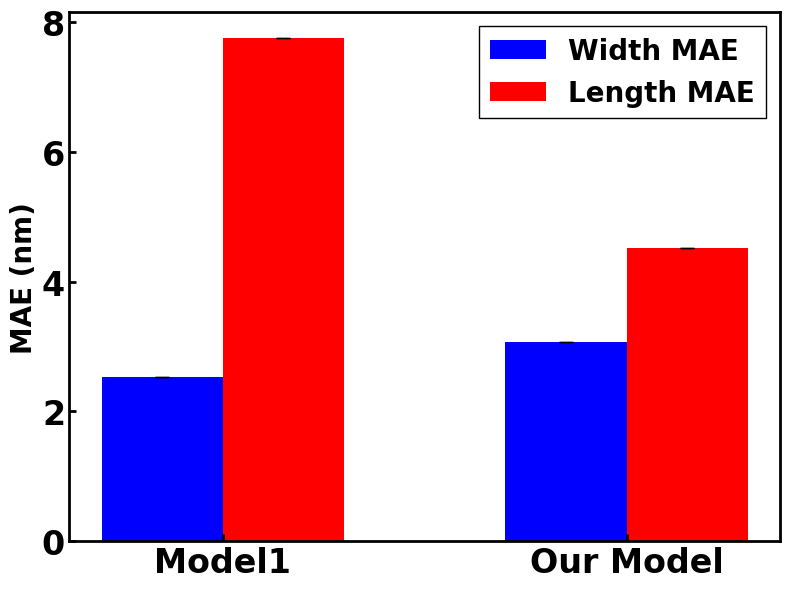

In [29]:
fig, ax = plt.subplots()

Width_MAE = (maew1_array.mean(), maew2_array.mean())
Length_MAE = (mael1_array.mean(), mael2_array.mean())

Width_MAE_errors = (maew1_array.std(), maew2_array.std())
Length_MAE_errors = (mael1_array.std(), mael2_array.std())

n_groups = 2
index = np.arange(n_groups)
bar_width = 0.3
opacity = 1.0

ax.bar(index - bar_width / 2, Width_MAE, bar_width, alpha=opacity, color='b', label='Width MAE', align='center',
        yerr=Width_MAE_errors, capsize=5)  # Adding error bars for Width_MAE
ax.bar(index + bar_width / 2, Length_MAE, bar_width, alpha=opacity, color='r', label='Length MAE', align='center',
        yerr=Length_MAE_errors, capsize=5)  # Adding error bars for Length_MAE

plt.xticks(index, ('Model1', 'Our Model'))
ax.set_ylabel('MAE (nm)')

# ax1.set_yticks(np.arange(0.7, 1.0, 0.1))
# ax1.set_ylim(0.7, 1.05)

labels = ax.get_xticklabels()
plt.legend(fontsize=20)

Text(0, 0.5, 'MAE (nm)')

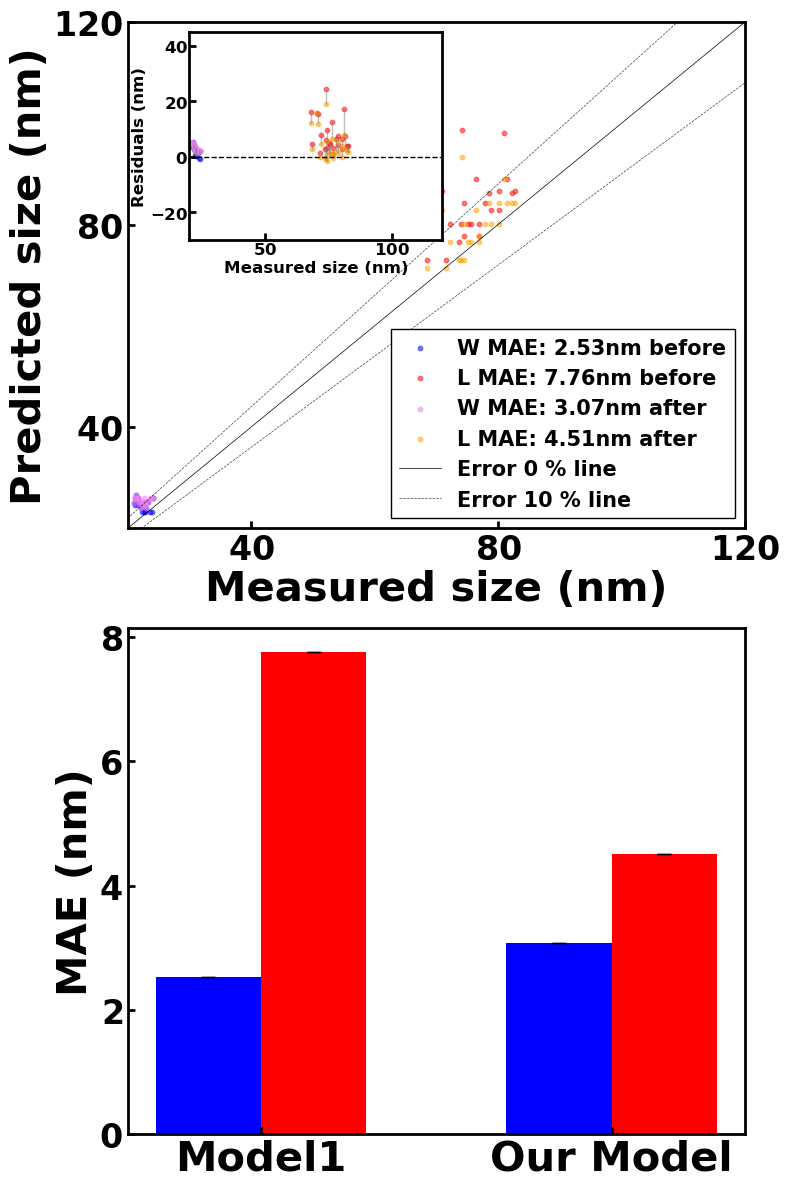

In [33]:
# Create the figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))  # 1 row, 2 columns

# First subplot
ax1.scatter(yw_al2o3, yw_pred1, s=10, c='b', alpha=.5, label=f'W MAE: {round(maew1_array.mean(), 2)}nm before')
ax1.scatter(yl_al2o3, yl_pred1, s=10, c='r', alpha=.5, label=f'L MAE: {round(mael1_array.mean(), 2)}nm before')

ax1.scatter(yw_al2o3, yw_pred2, s=10, c='violet', alpha=.5, label=f'W MAE: {round(maew2_array.mean(), 2)}nm after')
ax1.scatter(yl_al2o3, yl_pred2, s=10, c='orange', alpha=.5, label=f'L MAE: {round(mael2_array.mean(), 2)}nm after')

x = np.arange(-1, 181)
ax1.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax1.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax1.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax1.set_xticks([40, 80, 120])
ax1.set_yticks([40, 80, 120])
ax1.set_xlabel('Measured size (nm)', fontsize=30)
ax1.set_ylabel('Predicted size (nm)', fontsize=30)
ax1.set_xlim(20, 120)
ax1.set_ylim(20, 120)
ax1.legend(loc='lower right', fontsize=15)

# add_axes([left, bottom, width, height]) values are fractions of fig width and height
axins = ax1.inset_axes([0.1, 0.57, 0.41, 0.41])

# Plot on inset
# Glass to ITO
axins.scatter(yw_al2o3, yw_pred1-yw_al2o3, s=10, c='b', alpha=.5, label=f'MAE: {round(maew1_array.mean(), 2)} nm')
axins.scatter(yl_al2o3, yl_pred1-yl_al2o3, s=10, c='r', alpha=.5, label=f'MAE: {round(mael1_array.mean(), 2)} nm')

# Corrected Glass to ITO
axins.scatter(yw_al2o3, yw_pred2-yw_al2o3, s=10, c='violet', alpha=.5, label=f'MAE: {round(maew2_array.mean(), 2)} nm')
axins.scatter(yl_al2o3, yl_pred2-yl_al2o3, s=10, c='orange', alpha=.5, label=f'MAE: {round(mael2_array.mean(), 2)} nm')

for i in range(len(yw_al2o3)):
    axins.plot([yw_al2o3[i], yw_al2o3[i]], [yw_pred1[i] - yw_al2o3[i], yw_pred2[i] - yw_al2o3[i]], color='gray', lw=1, alpha=0.5)

for i in range(len(yl_al2o3)):
    axins.plot([yl_al2o3[i], yl_al2o3[i]], [yl_pred1[i] - yl_al2o3[i], yl_pred2[i] - yl_al2o3[i]], color='gray', lw=1, alpha=0.5)

axins.axhline(y=0, lw=1, ls="--", c='k')
axins.set_xlabel('Measured size (nm)', fontsize=12)
axins.set_ylabel('Residuals (nm)', fontsize=12)
axins.set_xticks([50, 100])
axins.set_yticks([-20, 0, 20, 40])
axins.tick_params(axis='x', labelsize=12, pad=1)
axins.tick_params(axis='y', labelsize=12, pad=1) 
axins.set_xlim(20, 120)
axins.set_ylim(-30, 45)

# Second subplot
Width_MAE = (maew1_array.mean(), maew2_array.mean())
Length_MAE = (mael1_array.mean(), mael2_array.mean())

Width_MAE_errors = (maew1_array.std(), maew2_array.std())
Length_MAE_errors = (mael1_array.std(), mael2_array.std())

n_groups = 2
index = np.arange(n_groups)
bar_width = 0.3
opacity = 1.0

ax2.bar(index - bar_width / 2, Width_MAE, bar_width, alpha=opacity, color='b', label='Width MAE', align='center',
        yerr=Width_MAE_errors, capsize=5)  # Adding error bars for Width_MAE
ax2.bar(index + bar_width / 2, Length_MAE, bar_width, alpha=opacity, color='r', label='Length MAE', align='center',
        yerr=Length_MAE_errors, capsize=5)  # Adding error bars for Length_MAE

ax2.set_xticks(index, ('Model1', 'Our Model'), fontsize=30)
ax2.set_ylabel('MAE (nm)', fontsize=30)